### Валидация данных. Методы валидации.

In [18]:
# Загрузка необходимых библиотек

import numpy as np #для матричных вычислений
import pandas as pd #для обработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений

# Устанавливаем стиль визуализаций в matplotlib
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [ ]:
#Первичный анализ дата-сета
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [20]:
#Проанализируем пропуски в %
display(water_data.isnull().mean()*100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

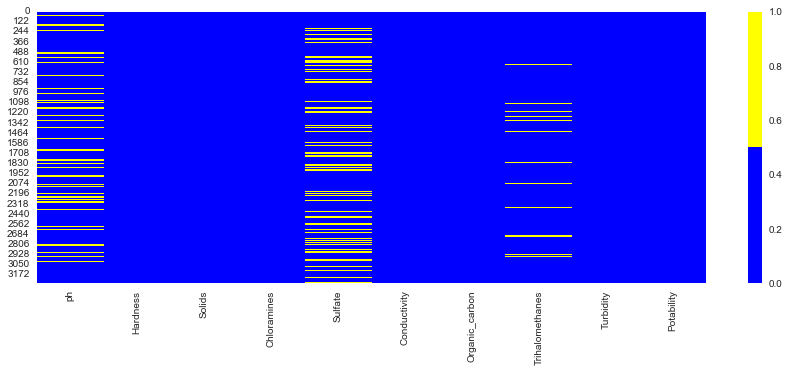

In [21]:
cols_with_null = water_data.isnull().mean()*100
#через тепловую карту
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(15, 5))
cols = cols_with_null.index
ax = sns.heatmap(
    water_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

In [22]:
#Заполним пропуски медаиной в зависимост от класса воды
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

In [23]:
# проверям заполнение пропусков
display(water_data.isnull().mean()*100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

In [35]:
# Разделим выборку на набор данных X и вектор ответов y
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

In [39]:
# Разбиваем датасет на выборки со стратификацией по y
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42, #генератор случайных чисел
    class_weight='balanced' #веса классов
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик    
print(metrics.classification_report(y_valid, y_valid_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       400
           1       0.63      0.76      0.69       256

    accuracy                           0.73       656
   macro avg       0.72      0.73      0.72       656
weighted avg       0.74      0.73      0.73       656



#### Валидационный метод HOLD-OUT

In [26]:
# Разобъем датасет на тренировочную и тестовую (валидационную) выборки
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_valid.shape}')

Train shape: (2620, 9)
Test shape: (656, 9)


Для обучения применим модель Деревья решений: глубина 7, число объектов в листе 5, критерий информативности энтропия.

In [27]:
#Создаем и настраиваем модель
model = tree.DecisionTreeClassifier (
    criterion='entropy', #криетрий информативности
    max_depth=7, #глубина дерева
    min_samples_leaf=5, #число объектов в листе
    random_state=42 #число воспроизводимости
)

#Обучение модели на тренировочной выборке
model.fit(X_train, y_train)

# Делаем предсказание модели на двух выборках
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# Выводим значение метрик
print(f'Train Hold-out accuracy {metrics.accuracy_score(y_train, y_train_pred):.2}')
print(f'Valid Hold-out accuracy {metrics.accuracy_score(y_valid, y_valid_pred):.2}')

Train Hold-out accuracy 0.82
Valid Hold-out accuracy 0.77


Трехкомпонентный подход

In [28]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

print(f'Train shape: {X_train.shape}')
print(f'Valid shape: {X_valid.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом случае мы будем обучаться на 2620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

#### 

#### Валидационный метод K-FOLD

In [29]:
#Создаем модель деревья решений
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

#Создаем объект кросс-валидаттор K-FOLD
kf = model_selection.KFold(n_splits=5)

#Создаем списки для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []

#Реализуем цикл для крос-валидации с использованием всего набора данных
# train_index - индексы тренировочной выборки
# valid_index - индексы валидационных выборки
for train_index, valid_index in kf.split(X, y):
    #Создаем тренировочную и валидационную выборки, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    
    #Рассчитываем метрику и заносим ее в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

In [30]:
# Просмотрим списки train_metrics и val_metrics
print(train_metrics)
print(val_metrics)

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик

In [31]:
print(f'Train k-fold mean accuracy:{np.mean(train_metrics):.2}')
print(f'Valid k-fold mean accuracy:{np.mean(val_metrics):.2}')

Train k-fold mean accuracy:0.81
Valid k-fold mean accuracy:0.74


#### Функция для кросс-валидации
как нужно делать

In [32]:
#Создаем модель деревья решений
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

#Создаем объект кросс-валидаттор K-FOLD
kf = model_selection.KFold(n_splits=5)

#Подсчитываем метрики кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений Х
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчет метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.04986572, 0.05585933, 0.06459403, 0.09374666, 0.29026055]),
 'score_time': array([0.00598383, 0.00697374, 0.00199747, 0.00199556, 0.00300074]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

Рассчитаем среднее по метрикам

In [33]:
print(f'Train k-fold mean accuracy:{np.mean(cv_metrics["train_score"]):.2}')
print(f'Valid k-fold mean accuracy:{np.mean(cv_metrics["test_score"]):.2}')

Train k-fold mean accuracy:0.81
Valid k-fold mean accuracy:0.74


#### Метод кросс-валидации LEAV-ONE-OUT

In [34]:
#Создаем модель деревья решений
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42
)

# создаем кросс-валидатор LeavOneOut
loo = model_selection.LeaveOneOut()

# Считаем метрики кросс-валидации leav-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model,
    X=X.iloc[:500], #матрица наблюдений от 0 до 500
    y=y.iloc[:500], #вектор ответов y от 0 до 500
    cv=loo,
    scoring='accuracy', #метрика
    return_train_score=True #вернуть подсчет метрики на тренировочных фолдах
)

print(f'Train k-fold mean accuracy:{np.mean(cv_metrics["train_score"]):.2}')
print(f'Valid k-fold mean accuracy:{np.mean(cv_metrics["test_score"]):.2}')

Train k-fold mean accuracy:0.95
Valid k-fold mean accuracy:0.9
